In [1]:
import sys
import os
import matplotlib.pyplot as plt
import numpy as np
from tensorflow.keras.models import load_model
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.preprocessing.image import img_to_array, load_img

sys.path.append(os.path.abspath(os.path.join(".."))) 
import seaborn as sns
import tensorflow as tf


from src.preprocessing import create_data_generators
from src.model import create_model, train_model, save_model, load_trained_model,retrain_model
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from tensorflow.keras.applications.vgg16 import preprocess_input
from src.upload_handler import upload_data

In [2]:
train_dir = r"C:\Users\fadhl\OneDrive\Desktop\ML_pipeline_summative\data\train"
test_dir = r"C:\Users\fadhl\OneDrive\Desktop\ML_pipeline_summative\data\test"
model_path = r"C:\Users\fadhl\OneDrive\Desktop\ML_pipeline_summative\models\chest_xray_model.keras"
new_data_dir = "data/new_images"

# Where retrained models will be saved
output_model_dir = r"C:\Users\fadhl\OneDrive\Desktop\ML_pipeline_summative\models"
os.makedirs(output_model_dir, exist_ok=True)
img_size = (224, 224)
batch_size = 32

### DATA PREPROCESSING

In [3]:
# Create data generators
train_gen, val_gen, test_gen = create_data_generators(
    train_dir=train_dir,
    test_dir=test_dir,
    img_size=img_size,
    batch_size=batch_size,
    validation_split=0.2
)

Found 3692 images belonging to 2 classes.
Found 922 images belonging to 2 classes.
Found 541 images belonging to 2 classes.


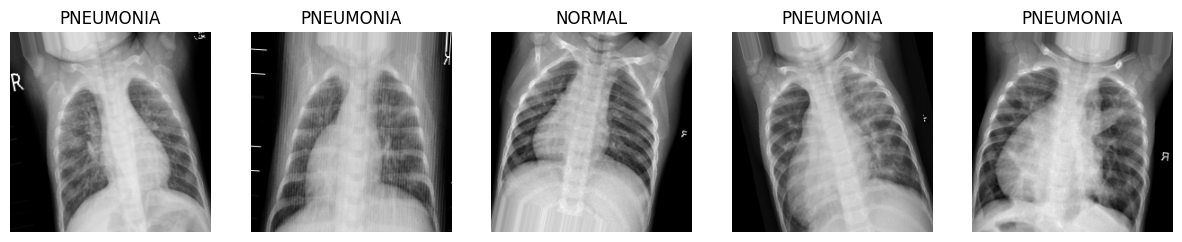

In [4]:
def plot_sample_images(generator, n=5):
    x, y = next(generator)
    plt.figure(figsize=(15, 3))
    
    for i in range(n):
        plt.subplot(1, n, i + 1)
        
        # Undo VGG16 preprocessing for visualization
        img = x[i].copy()
        img[..., 0] += 103.939  # B channel
        img[..., 1] += 116.779  # G channel
        img[..., 2] += 123.68   # R channel
        img = img[..., ::-1]     # BGR -> RGB
        img = np.clip(img / 255.0, 0, 1)  # scale to [0,1] for plt.imshow
        
        plt.imshow(img)
        plt.title("PNEUMONIA" if y[i] == 1 else "NORMAL")
        plt.axis('off')
    
    plt.show()

plot_sample_images(train_gen)

### MODEL TRAINING

In [5]:
# Create the VGG16 model
model = create_model(input_shape=(224, 224, 3), l2_factor=0.0001, dropout_rate=0.3)
model.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ get_item (GetItem)  │ (None, 224, 224)  │          0 │ input_layer_1[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ get_item_1          │ (None, 224, 224)  │          0 │ input_layer_1[0]… │
│ (GetItem)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ get_item_2          │ (None, 224, 224)  │          0 │ input_layer_1[0]… │
│ (GetItem)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stack (Stack)       │ (None, 224, 224,  │          0 │ get_item[0][0],   │
│                     │ 3)                │            │ get_item_1[0][0], │
│                     │                   │            │ get_item_2[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 224, 224,  │          0 │ stack[0][0]       │
│                     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ vgg16 (Functional)  │ (None, 7, 7, 512) │ 14,714,688 │ add[0][0]         │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten (Flatten)   │ (None, 25088)     │          0 │ vgg16[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 512)       │ 12,845,568 │ flatten[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 512)       │      2,048 │ dense[0][0]       │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 512)       │          0 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 128)       │     65,664 │ dropout[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128)       │        512 │ dense_1[0][0]     │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 128)       │          0 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 1)         │        129 │ dropout_1[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 27,628,609 (105.39 MB)

 Trainable params: 12,912,641 (49.26 MB)

 Non-trainable params: 14,715,968 (56.14 MB)

In [6]:
# Train the model
history = train_model(
    model,
    train_generator=train_gen,
    validation_generator=val_gen,
    epochs=10,
    model_path=model_path,
    fine_tune=True
)


c:\Users\fadhl\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
116/116 ━━━━━━━━━━━━━━━━━━━━ 1324s 11s/step - accuracy: 0.7996 - auc: 0.9153 - loss: 0.5970 - precision: 0.9635 - recall: 0.7656 - val_accuracy: 0.9252 - val_auc: 0.9896 - val_loss: 0.3529 - val_precision: 0.9923 - val_recall: 0.9093
Epoch 2/10
116/116 ━━━━━━━━━━━━━━━━━━━━ 1295s 11s/step - accuracy: 0.9326 - auc: 0.9817 - loss: 0.3403 - precision: 0.9868 - recall: 0.9230 - val_accuracy: 0.9729 - val_auc: 0.9958 - val_loss: 0.2078 - val_precision: 0.9899 - val_recall: 0.9745
Epoch 3/10
116/116 ━━━━━━━━━━━━━━━━━━━━ 1289s 11s/step - accuracy: 0.9444 - auc: 0.9881 - loss: 0.2892 - precision: 0.9844 - recall: 0.9426 - val_accuracy: 0.9620 - val_auc: 0.9910 - val_loss: 0.2332 - val_precision: 0.9827 - val_recall: 0.9674
Epoch 4/10
116/116 ━━━━━━━━━━━━━━━━━━━━ 1300s 11s/step - accuracy: 0.9495 - auc: 0.9830 - loss: 0.2912 - precision: 0.9811 - recall: 0.9524 - val_accuracy: 0.9772 - val_auc: 0.9963 - val_loss: 0.1802 - val_precision: 0.9777 - val_recall: 0.9929
Epoch 5/10
116/116 ━

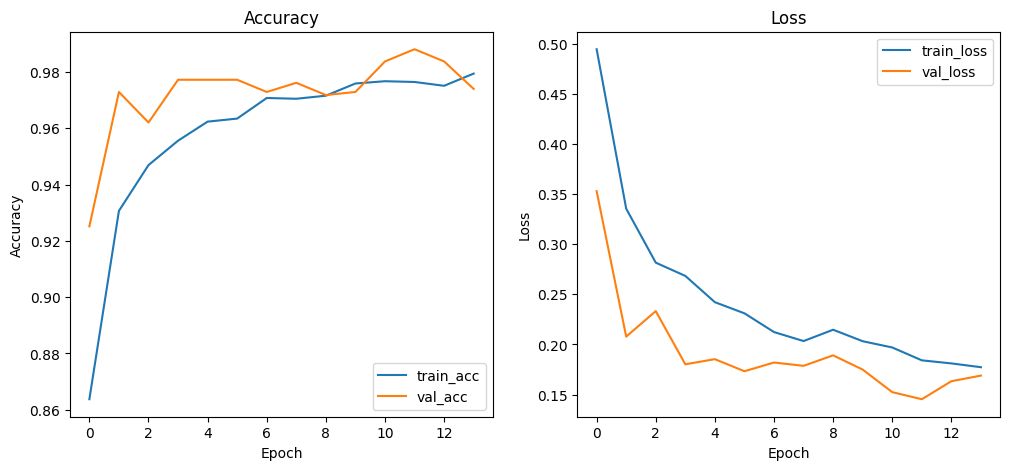

In [7]:
#Plot learning curve
plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='train_acc')
plt.plot(history.history['val_accuracy'], label='val_acc')
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='train_loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.show()


### MODEL EVALUATION


In [8]:
y_pred_prob = model.predict(test_gen)
y_pred = (y_pred_prob > 0.5).astype(int).flatten()
y_true = test_gen.classes

17/17 ━━━━━━━━━━━━━━━━━━━━ 148s 9s/step


In [9]:
acc = accuracy_score(y_true, y_pred)
prec = precision_score(y_true, y_pred)
rec = recall_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred)
auc = roc_auc_score(y_true, y_pred_prob)
loss_fn = tf.keras.losses.BinaryCrossentropy()
loss = loss_fn(y_true, y_pred_prob).numpy()

In [10]:
print("Test Loss:", loss)
print("Test Accuracy:", acc)
print("Test Precision:", prec)
print("Test Recall:", rec)
print("Test F1 Score:", f1)
print("Test AUC:", auc)

Test Loss: 0.13344917
Test Accuracy: 0.966728280961183
Test Precision: 0.9686609686609686
Test Recall: 0.9798270893371758
Test F1 Score: 0.9742120343839542
Test AUC: 0.9871208294958257


              precision    recall  f1-score   support

      NORMAL       0.96      0.94      0.95       194
   PNEUMONIA       0.97      0.98      0.97       347

    accuracy                           0.97       541
   macro avg       0.97      0.96      0.96       541
weighted avg       0.97      0.97      0.97       541



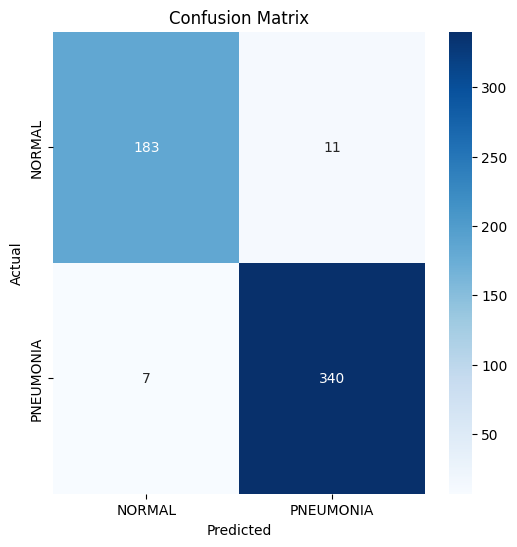

In [11]:
# Classification report and confusion matrix
print(classification_report(y_true, y_pred, target_names=list(test_gen.class_indices.keys())))

cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(6,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=list(test_gen.class_indices.keys()),
            yticklabels=list(test_gen.class_indices.keys()))
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

In [12]:
model.save(model_path)
print(f"Model saved at {model_path}")

Model saved at C:\Users\fadhl\OneDrive\Desktop\ML_pipeline_summative\models\chest_xray_model.keras


## TESTING THE MODEL

In [13]:
model = tf.keras.models.load_model(model_path)
print("Model loaded successfully")


Model loaded successfully


In [14]:
def preprocess_single_image(image_path):
    img = load_img(image_path, target_size=(224, 224))
    img_array = img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = preprocess_input(img_array)
    return img_array


In [15]:
def predict_image(image_path, model):
    processed = preprocess_single_image(image_path)
    prediction = model.predict(processed)[0][0]

    label = "PNEUMONIA" if prediction > 0.5 else "NORMAL"
    confidence = prediction if prediction > 0.5 else 1 - prediction

    return label, float(confidence)


In [ ]:
test_image = r"C:\Users\fadhl\OneDrive\Desktop\ML_pipeline_summative\VIRUS-9947411-0002.jpeg" 

label, confidence = predict_image(test_image, model)

print("Prediction:", label)
print("Confidence:", confidence)


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
Prediction: PNEUMONIA
Confidence: 0.9580252766609192


### TESTING THE RETRAINING FUNCTION

In [4]:
upload_source = r"C:\Users\fadhl\Downloads\NEW XRAY IMAGES\chest_xray\val"
upload_target = r"C:\Users\fadhl\OneDrive\Desktop\ML_pipeline_summative\data\new_uploads"



In [4]:
upload_widget = upload_data(upload_target_folder=  r"C:\Users\fadhl\OneDrive\Desktop\ML_pipeline_summative\data\new_uploads"
, use_gui=True)


FileUpload(value=(), accept='image/*', description='Upload', multiple=True)

In [4]:
new_model_path, history = retrain_model(
    new_data_folder=new_data_dir,
    original_train_folder=train_dir,
    batch_size=batch_size,
    epochs=5,
    output_directory=output_model_dir,
    fine_tune=True
)


Starting retraining process
New data merged into training folder
Found 3692 images belonging to 2 classes.
Found 922 images belonging to 2 classes.
Loaded model from C:\Users\fadhl\OneDrive\Desktop\ML_pipeline_summative\models\model_20251120_234806.keras


c:\Users\fadhl\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/5
116/116 ━━━━━━━━━━━━━━━━━━━━ 1598s 14s/step - accuracy: 0.9852 - auc: 0.9953 - loss: 0.1663 - precision: 0.9883 - recall: 0.9921 - val_accuracy: 0.9761 - val_auc: 0.9974 - val_loss: 0.1551 - val_precision: 0.9831 - val_recall: 0.9858
Epoch 2/5
116/116 ━━━━━━━━━━━━━━━━━━━━ 1592s 14s/step - accuracy: 0.9842 - auc: 0.9962 - loss: 0.1526 - precision: 0.9889 - recall: 0.9903 - val_accuracy: 0.9870 - val_auc: 0.9992 - val_loss: 0.1340 - val_precision: 0.9929 - val_recall: 0.9901
Epoch 3/5
116/116 ━━━━━━━━━━━━━━━━━━━━ 1618s 14s/step - accuracy: 0.9784 - auc: 0.9949 - loss: 0.1653 - precision: 0.9892 - recall: 0.9822 - val_accuracy: 0.9794 - val_auc: 0.9985 - val_loss: 0.1483 - val_precision: 0.9872 - val_recall: 0.9858
Epoch 4/5
116/116 ━━━━━━━━━━━━━━━━━━━━ 1588s 14s/step - accuracy: 0.9876 - auc: 0.9990 - loss: 0.1420 - precision: 0.9931 - recall: 0.9908 - val_accuracy: 0.9848 - val_auc: 0.9992 - val_loss: 0.1339 - val_precision: 0.9915 - val_recall: 0.9887
Epoch 5/5
116/116 ━━━━━━

In [5]:
model = load_trained_model(new_model_path)


Loaded model from C:\Users\fadhl\OneDrive\Desktop\ML_pipeline_summative\models\model_20251121_024952.keras


In [7]:
y_pred_prob = model.predict(test_gen)
y_pred = (y_pred_prob > 0.5).astype(int).flatten()
y_true = test_gen.classes

17/17 ━━━━━━━━━━━━━━━━━━━━ 169s 10s/step


In [8]:
acc = accuracy_score(y_true, y_pred)
prec = precision_score(y_true, y_pred)
rec = recall_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred)
auc = roc_auc_score(y_true, y_pred_prob)
loss_fn = tf.keras.losses.BinaryCrossentropy()
loss = loss_fn(y_true, y_pred_prob).numpy()

              precision    recall  f1-score   support

      NORMAL       0.99      0.76      0.86       194
   PNEUMONIA       0.88      1.00      0.94       347

    accuracy                           0.91       541
   macro avg       0.94      0.88      0.90       541
weighted avg       0.92      0.91      0.91       541



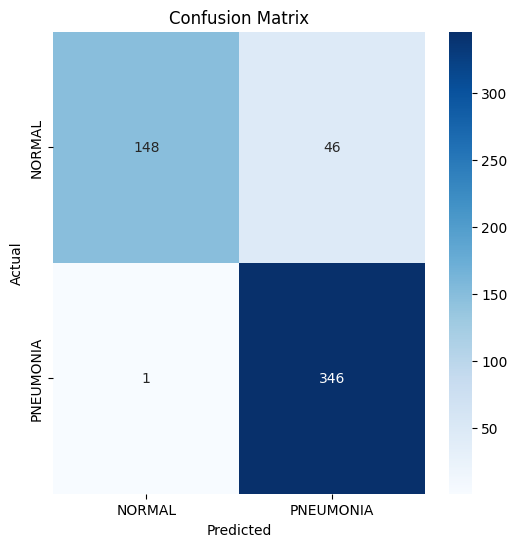

In [9]:
# Classification report and confusion matrix
print(classification_report(y_true, y_pred, target_names=list(test_gen.class_indices.keys())))

cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(6,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=list(test_gen.class_indices.keys()),
            yticklabels=list(test_gen.class_indices.keys()))
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()